In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [114]:
step_size_eps = 0.1

def step_size_calc(curr_t):
    return step_size_eps*smoothing_var(curr_t)

def smoothing_var(curr_t):
    return (1 - math.exp(-2*curr_t))

def single_gaussian_score(curr_x, curr_t, start_rho, end_rho=1):
    return -curr_x / (1 - (1 - rho**2)*math.exp(-2*curr_t))

def two_gaussian_score(curr_x, curr_t, mean1=0, mean2=0, rho1 = 1, rho2=1):
    var1 = (1 - (1 - rho1**2)*np.exp(-2*curr_t))
    var2 = (1 - (1 - rho2**2)*np.exp(-2*curr_t))
    a = np.exp(-(curr_x-mean1)**2/(2*var1))
    b = np.exp(-(curr_x-mean2)**2/(2*var2))
    c = -(curr_x-mean1)/(var1) * a
    d = -(curr_x-mean2)/(var2) * b
    
    return (c + d) / (a + b)

def iterate_backward(curr_x, curr_t, score_func, step_size = 0, linear=True, **kwargs):
    if linear and step_size == 0:
        return False
    if linear:
        return iterate_backward_linear(curr_x, curr_t, step_size, score_func, **kwargs)
    return iterate_backward_stepsize(curr_x, curr_t, score_func, **kwargs)
        
def iterate_backward_linear(curr_x, curr_t, step_size, score_func, **kwargs):
    curr_score = score_func(curr_x, curr_t, **kwargs)
    mean = math.exp(step_size)*curr_x + 2*curr_score*(math.exp(step_size) - 1)
    stddev = math.sqrt(math.exp(2*step_size) - 1)
    curr_t -= step_size
    return (np.random.normal(mean, stddev), curr_t)

def iterate_backward_stepsize(curr_x, curr_t, score_func, **kwargs):
    curr_score = score_func(curr_x, curr_t, **kwargs)
    step_size = step_size_calc(curr_t)
    ret = True
    if step_size < 0.00001:
        ret = False
    mean = math.exp(step_size)*curr_x + 2*curr_score*(math.exp(step_size) - 1)
    stddev = math.sqrt(math.exp(2*step_size) - 1)
    curr_t -= step_size
    return (np.random.normal(mean, stddev), curr_t, ret)

def iterate_forward(curr_x, curr_t, step_size):
    mean = math.exp(-step_size)*curr_x
    stddev = math.sqrt(1 - math.exp(-2*step_size))
    curr_t += step_size
    return (np.random.normal(mean, stddev), curr_t)

def run_backward_process(data, curr_t, score_func, track_func, given_step_sizes = [], **kwargs):
    init = np.copy(data)
    count = 0
    sb = [track_func(init)]
    while curr_t > 0.000000001:
        if len(given_step_sizes) != 0:
            init, curr_t = iterate_backward(init, curr_t, score_func, step_size=given_step_sizes[count], linear=True, **kwargs)
        else:
            init, curr_t, ret = iterate_backward(init, curr_t, score_func, linear=False, **kwargs)
            if not ret:
                break
        count+=1
        sb.append(track_func(init))
    print("NUM_STEPS: ", count, " END TIME: ", curr_t)
    if len(np.shape(init)) == 1:
        plt.hist(init, bins=np.linspace(min(init), max(init), 100), label="stddev:{}".format(track_func(init)))
        plt.legend()
        plt.show()
    return sb
def std(data):
    return np.mean(np.std(data, axis=0))
def split_std(data):
    return (np.std(data[data < 0]) + np.std(data[data > 0])) / 2
def run_forward_process(data, ss, track_func, goal_val):
    init = np.copy(data)
    sf = [track_func(init)]
    count = 0
    curr_t = 0
    while abs(track_func(init) - goal_val) > 0.0001*goal_val:
        count+=1
        init, curr_t = iterate_forward(init, curr_t, ss)
        sf.append(track_func(init))
    if len(np.shape(init)) == 1:
        plt.hist(init, bins=np.linspace(min(init), max(init), 100), label="stddev:{}".format(track_func(init)))
        plt.legend()
        plt.show()
    return (init, sf, count, curr_t)
def quad_time(total_t, init_step, step_diff):
    curr_step = init_step
    steps = [curr_step]
    t = 0
    while t < total_t:
        t += curr_step
        curr_step += step_diff
        steps.append(curr_step)
    return steps[:-1][::-1]

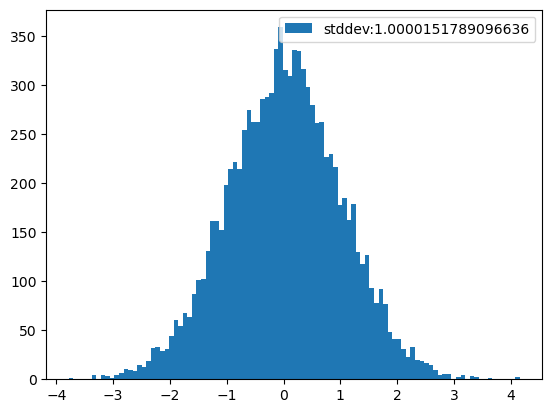

NUM_STEPS:  33611  END TIME:  3.367802998283098e-16


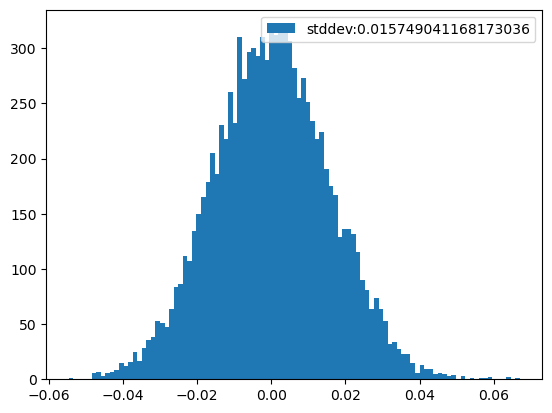

NUM_STEPS:  75  END TIME:  3.928316149882434e-05


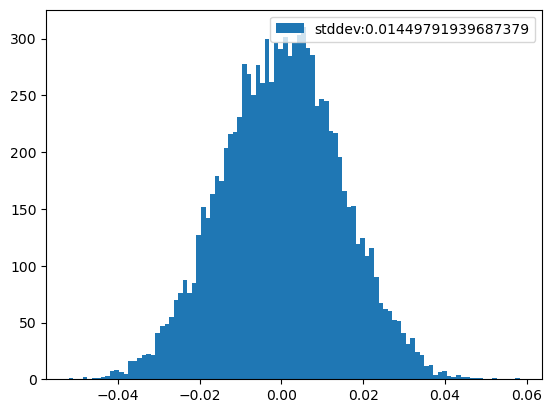

NUM_STEPS:  789  END TIME:  -3.999999729929413e-05


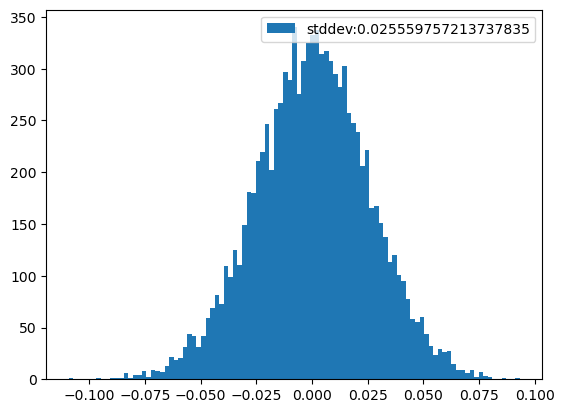

In [120]:
num_samples = 10000
rho = 0.01
# ss = step_size_eps**2 * rho**4
ss = 0.0001

init = np.random.normal(0, rho, size=num_samples)

init, sf, count, curr_t = run_forward_process(init, ss, std, 1)

sb1 = run_backward_process(init, 
                           curr_t, 
                           single_gaussian_score,
                           std,
                           given_step_sizes = ss * np.ones(count), 
                           start_rho=rho)
sb2 = run_backward_process(init, 
                           curr_t, 
                           single_gaussian_score, 
                           std,
                           given_step_sizes = [], 
                           start_rho=rho)
sbq = run_backward_process(init, 
                           curr_t, 
                           single_gaussian_score, 
                           std,
                           given_step_sizes = quad_time(curr_t, ss/10, ss/10), 
                           start_rho=rho)

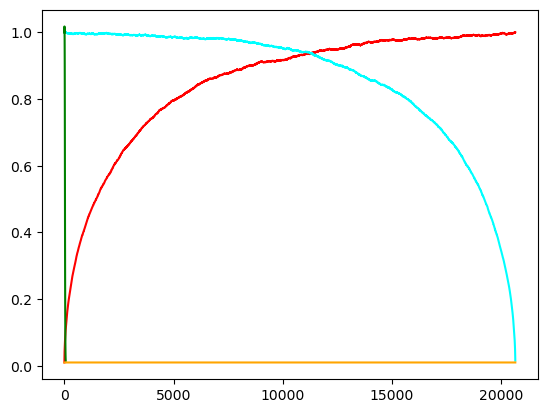

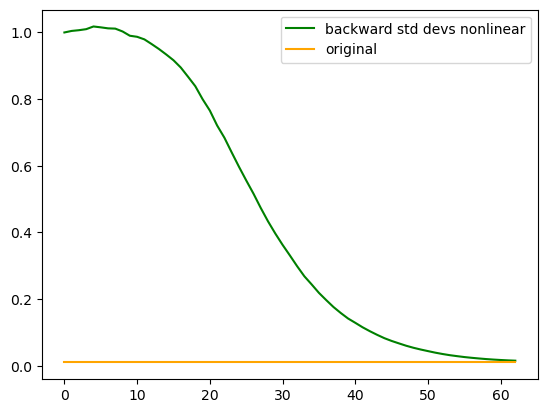

In [119]:
plt.plot(sf, color="red", label="forward std devs")
plt.plot(sb1, color="cyan", label="backward std devs linear")
plt.plot(sb2, color="green", label="backward std devs nonlinear")
# plt.plot(sbq, color="orange", label="backward std devs quad")
plt.plot(rho*np.ones(max(len(sb2), len(sb1))), color="orange", label="original")
# plt.legend()
plt.show()

plt.plot(sb2, color="green", label="backward std devs nonlinear")
# plt.plot(sbq, color="red", label="backward std devs quad")
plt.plot(rho*np.ones(max(len(sb2), len(sb2))), color="orange", label="original")
plt.legend()
plt.show()

0.009968779486706984


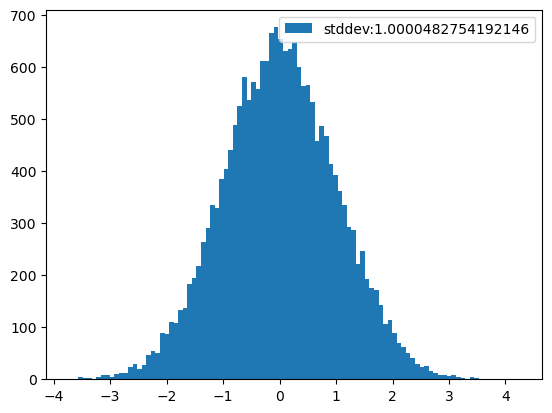

2595 6.938893903907228e-18


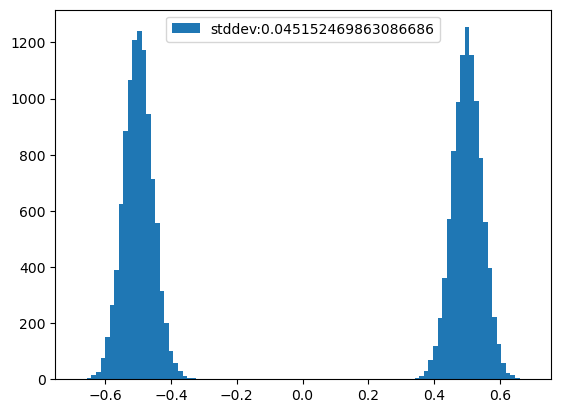

68 3.374686962287213e-05


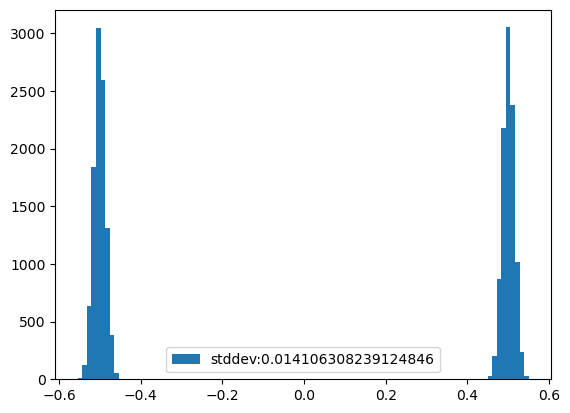

211 -0.00030000000016846477


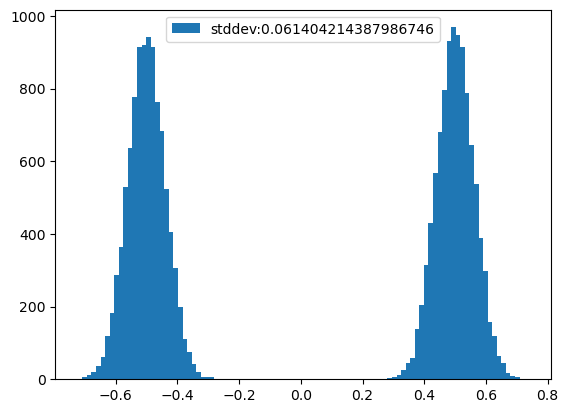

In [104]:
num_samples = 10000
rho = 0.01
# ss = step_size_eps**2 * rho**2
ss = 0.001
mean1 = -0.5
mean2 = 0.5
init = np.append(np.random.normal(mean1, rho, size=num_samples), np.random.normal(mean2, rho, size=num_samples))
print(split_std(init))

init, sf, count, curr_t = run_forward_process(init, ss, std, 1)

sb1 = run_backward_process(init, 
                           curr_t, 
                           two_gaussian_score, 
                           split_std,
                           given_step_sizes = ss * np.ones(count), 
                           mean1=mean1, 
                           mean2=mean2, 
                           rho1 = rho, 
                           rho2 = rho)
sb2 = run_backward_process(init, 
                           curr_t, 
                           two_gaussian_score, 
                           split_std,
                           given_step_sizes=[],
                           mean1=mean1, 
                           mean2=mean2, 
                           rho1 = rho, 
                           rho2 = rho)
sbq = run_backward_process(init, 
                           curr_t, 
                           two_gaussian_score, 
                           split_std,
                           given_step_sizes=quad_time(curr_t, ss/10, ss/10),
                           mean1=mean1, 
                           mean2=mean2, 
                           rho1 = rho, 
                           rho2 = rho)

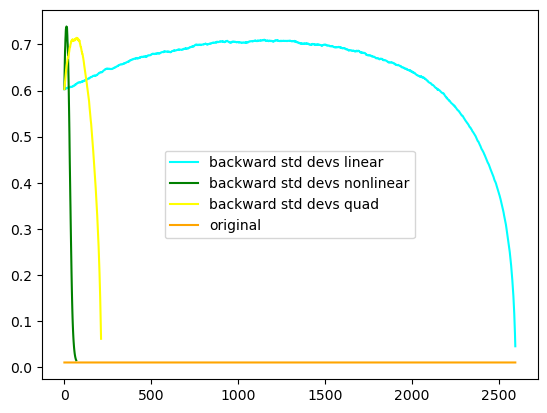

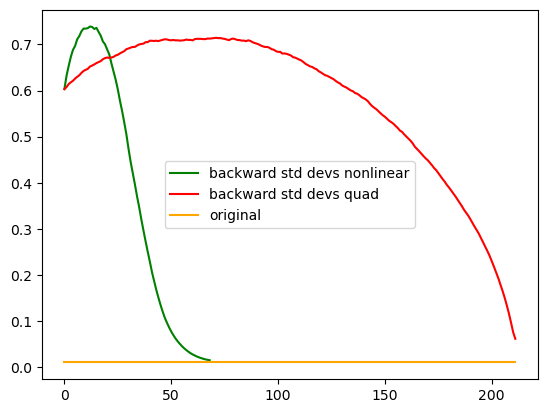

In [105]:
# plt.plot(sf, color="red", label="forward std devs")
plt.plot(sb1, color="cyan", label="backward std devs linear")
plt.plot(sb2, color="green", label="backward std devs nonlinear")
plt.plot(sbq, color="yellow", label="backward std devs quad")
plt.plot(rho*np.ones(max(len(sb2), len(sb1))), color="orange", label="original")
plt.legend()
plt.show()

plt.plot(sb2, color="green", label="backward std devs nonlinear")
plt.plot(sbq, color="red", label="backward std devs quad")
plt.plot(rho*np.ones(max(len(sb2), len(sbq))), color="orange", label="original")
plt.legend()
plt.show()

In [115]:
num_samples = 10000
rho = 0.01
# ss = step_size_eps**2 * rho**4
ss = 0.001
d = 4

init = np.random.normal(0, rho, size=(num_samples, d))

init, sf, count, curr_t = run_forward_process(init, ss, std, 1)

sb1 = run_backward_process(init, 
                           curr_t, 
                           single_gaussian_score,
                           std,
                           given_step_sizes = ss * np.ones(count), 
                           start_rho=rho)
sb2 = run_backward_process(init, 
                           curr_t, 
                           single_gaussian_score, 
                           std,
                           given_step_sizes = [], 
                           start_rho=rho)
sbq = run_backward_process(init, 
                           curr_t, 
                           single_gaussian_score, 
                           std,
                           given_step_sizes = quad_time(curr_t, ss/10, ss/10), 
                           start_rho=rho)

NUM_STEPS:  2401  END TIME:  6.938893903907228e-18
NUM_STEPS:  66  END TIME:  3.4110163871253275e-05
NUM_STEPS:  207  END TIME:  -0.00020000000014843973


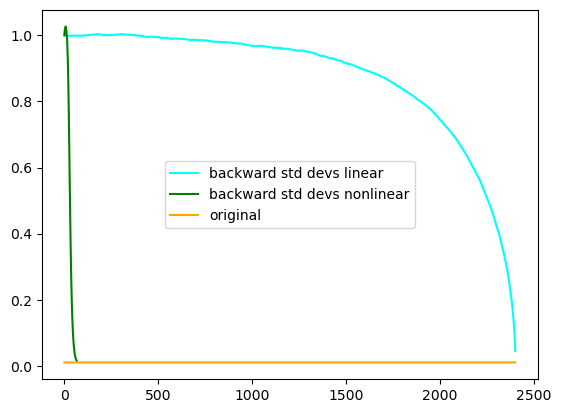

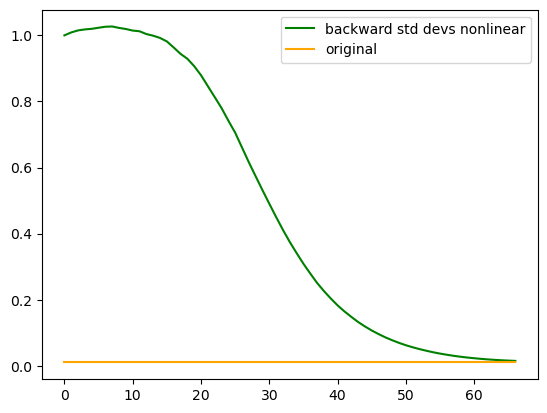

In [116]:
# plt.plot(sf, color="red", label="forward std devs")
plt.plot(sb1, color="cyan", label="backward std devs linear")
plt.plot(sb2, color="green", label="backward std devs nonlinear")
# plt.plot(sbq, color="yellow", label="backward std devs quad")
plt.plot(rho*np.ones(max(len(sb2), len(sb1))), color="orange", label="original")
plt.legend()
plt.show()

plt.plot(sb2, color="green", label="backward std devs nonlinear")
# plt.plot(sbq, color="red", label="backward std devs quad")
plt.plot(rho*np.ones(max(len(sb2), len(sb2))), color="orange", label="original")
plt.legend()
plt.show()

In [39]:
their_betas = np.array([0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0017,
        0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0018, 0.0018, 0.0018, 0.0018,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
        0.0018, 0.0018, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0022, 0.0022,
        0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0022, 0.0022, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023,
        0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0024, 0.0024,
        0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024,
        0.0024, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
        0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0026, 0.0026, 0.0026, 0.0026,
        0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
        0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0029, 0.0029, 0.0029, 0.0029,
        0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0030, 0.0030,
        0.0030, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030,
        0.0031, 0.0031, 0.0031, 0.0031, 0.0031, 0.0031, 0.0031, 0.0031, 0.0031,
        0.0031, 0.0031, 0.0031, 0.0032, 0.0032, 0.0032, 0.0032, 0.0032, 0.0032,
        0.0032, 0.0032, 0.0032, 0.0032, 0.0032, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0034, 0.0034, 0.0034,
        0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0035,
        0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035,
        0.0035, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036,
        0.0036, 0.0036, 0.0037, 0.0037, 0.0037, 0.0037, 0.0037, 0.0037, 0.0037,
        0.0037, 0.0037, 0.0037, 0.0038, 0.0038, 0.0038, 0.0038, 0.0038, 0.0038,
        0.0038, 0.0038, 0.0038, 0.0038, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0040, 0.0040, 0.0040, 0.0040,
        0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0041, 0.0041, 0.0041,
        0.0041, 0.0041, 0.0041, 0.0041, 0.0041, 0.0041, 0.0041, 0.0042, 0.0042,
        0.0042, 0.0042, 0.0042, 0.0042, 0.0042, 0.0042, 0.0042, 0.0043, 0.0043,
        0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0043, 0.0044,
        0.0044, 0.0044, 0.0044, 0.0044, 0.0044, 0.0044, 0.0044, 0.0044, 0.0045,
        0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0046,
        0.0046, 0.0046, 0.0046, 0.0046, 0.0046, 0.0046, 0.0046, 0.0046, 0.0046,
        0.0047, 0.0047, 0.0047, 0.0047, 0.0047, 0.0047, 0.0047, 0.0047, 0.0047,
        0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0051,
        0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0051, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0053,
        0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0054, 0.0054,
        0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054, 0.0055, 0.0055,
        0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0055, 0.0056, 0.0056, 0.0056,
        0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0057, 0.0057, 0.0057, 0.0057,
        0.0057, 0.0057, 0.0057, 0.0057, 0.0057, 0.0058, 0.0058, 0.0058, 0.0058,
        0.0058, 0.0058, 0.0058, 0.0058, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061,
        0.0061, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0064, 0.0064,
        0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0065, 0.0065, 0.0065,
        0.0065, 0.0065, 0.0065, 0.0065, 0.0065, 0.0066, 0.0066, 0.0066, 0.0066,
        0.0066, 0.0066, 0.0066, 0.0066, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068, 0.0068,
        0.0068, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0071, 0.0071,
        0.0071, 0.0071, 0.0071, 0.0071, 0.0071, 0.0072, 0.0072, 0.0072, 0.0072,
        0.0072, 0.0072, 0.0072, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073,
        0.0073, 0.0073, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0076, 0.0076,
        0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0077, 0.0077, 0.0077, 0.0077,
        0.0077, 0.0077, 0.0077, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
        0.0078, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0080,
        0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0081, 0.0081, 0.0081,
        0.0081, 0.0081, 0.0081, 0.0081, 0.0082, 0.0082, 0.0082, 0.0082, 0.0082,
        0.0082, 0.0082, 0.0083, 0.0083, 0.0083, 0.0083, 0.0083, 0.0083, 0.0083,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0085, 0.0085,
        0.0085, 0.0085, 0.0085, 0.0085, 0.0086, 0.0086, 0.0086, 0.0086, 0.0086,
        0.0086, 0.0086, 0.0087, 0.0087, 0.0087, 0.0087, 0.0087, 0.0087, 0.0087,
        0.0088, 0.0088, 0.0088, 0.0088, 0.0088, 0.0088, 0.0089, 0.0089, 0.0089,
        0.0089, 0.0089, 0.0089, 0.0089, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
        0.0090, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0091, 0.0092,
        0.0092, 0.0092, 0.0092, 0.0092, 0.0092, 0.0093, 0.0093, 0.0093, 0.0093,
        0.0093, 0.0093, 0.0093, 0.0094, 0.0094, 0.0094, 0.0094, 0.0094, 0.0094,
        0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0096, 0.0096,
        0.0096, 0.0096, 0.0096, 0.0096, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0098, 0.0098, 0.0098, 0.0098, 0.0098, 0.0098, 0.0098, 0.0099,
        0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0102,
        0.0102, 0.0102, 0.0102, 0.0102, 0.0102, 0.0103, 0.0103, 0.0103, 0.0103,
        0.0103, 0.0103, 0.0104, 0.0104, 0.0104, 0.0104, 0.0104, 0.0104, 0.0104,
        0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0106, 0.0106, 0.0106,
        0.0106, 0.0106, 0.0106, 0.0107, 0.0107, 0.0107, 0.0107, 0.0107, 0.0107,
        0.0108, 0.0108, 0.0108, 0.0108, 0.0108, 0.0108, 0.0109, 0.0109, 0.0109,
        0.0109, 0.0109, 0.0109, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
        0.0111, 0.0111, 0.0111, 0.0111, 0.0111, 0.0112, 0.0112, 0.0112, 0.0112,
        0.0112, 0.0112, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0114,
        0.0114, 0.0114, 0.0114, 0.0114, 0.0114, 0.0115, 0.0115, 0.0115, 0.0115,
        0.0115, 0.0115, 0.0116, 0.0116, 0.0116, 0.0116, 0.0116, 0.0116, 0.0117,
        0.0117, 0.0117, 0.0117, 0.0117, 0.0118, 0.0118, 0.0118, 0.0118, 0.0118,
        0.0118, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0120, 0.0120,
        0.0120])
our_betas = np.array([6.6102e-06, 6.8855e-06, 7.1723e-06, 7.4709e-06, 7.7820e-06, 8.1061e-06,
        8.4436e-06, 8.7952e-06, 9.1614e-06, 9.5428e-06, 9.9401e-06, 1.0354e-05,
        1.0785e-05, 1.1234e-05, 1.1702e-05, 1.2189e-05, 1.2696e-05, 1.3225e-05,
        1.3775e-05, 1.4348e-05, 1.4945e-05, 1.5567e-05, 1.6215e-05, 1.6890e-05,
        1.7593e-05, 1.8325e-05, 1.9087e-05, 1.9881e-05, 2.0708e-05, 2.1570e-05,
        2.2467e-05, 2.3401e-05, 2.4374e-05, 2.5388e-05, 2.6444e-05, 2.7543e-05,
        2.8688e-05, 2.9881e-05, 3.1123e-05, 3.2416e-05, 3.3763e-05, 3.5166e-05,
        3.6627e-05, 3.8149e-05, 3.9734e-05, 4.1384e-05, 4.3102e-05, 4.4892e-05,
        4.6756e-05, 4.8696e-05, 5.0717e-05, 5.2822e-05, 5.5013e-05, 5.7295e-05,
        5.9672e-05, 6.2146e-05, 6.4722e-05, 6.7405e-05, 7.0198e-05, 7.3106e-05,
        7.6134e-05, 7.9287e-05, 8.2569e-05, 8.5986e-05, 8.9544e-05, 9.3248e-05,
        9.7104e-05, 1.0112e-04, 1.0530e-04, 1.0965e-04, 1.1417e-04, 1.1889e-04,
        1.2379e-04, 1.2890e-04, 1.3421e-04, 1.3974e-04, 1.4550e-04, 1.5149e-04,
        1.5773e-04, 1.6421e-04, 1.7097e-04, 1.7799e-04, 1.8530e-04, 1.9290e-04,
        2.0082e-04, 2.0905e-04, 2.1761e-04, 2.2652e-04, 2.3578e-04, 2.4542e-04,
        2.5544e-04, 2.6586e-04, 2.7670e-04, 2.8797e-04, 2.9969e-04, 3.1187e-04,
        3.2454e-04, 3.3770e-04, 3.5139e-04, 3.6561e-04, 3.8039e-04, 3.9575e-04,
        4.1171e-04, 4.2829e-04, 4.4552e-04, 4.6341e-04, 4.8199e-04, 5.0129e-04,
        5.2133e-04, 5.4213e-04, 5.6373e-04, 5.8614e-04, 6.0940e-04, 6.3354e-04,
        6.5858e-04, 6.8456e-04, 7.1150e-04, 7.3944e-04, 7.6840e-04, 7.9842e-04,
        8.2954e-04, 8.6178e-04, 8.9518e-04, 9.2978e-04, 9.6561e-04, 1.0027e-03,
        1.0411e-03, 1.0808e-03, 1.1219e-03, 1.1644e-03, 1.2084e-03, 1.2538e-03,
        1.3007e-03, 1.3492e-03, 1.3993e-03, 1.4510e-03, 1.5044e-03, 1.5595e-03,
        1.6163e-03, 1.6749e-03, 1.7352e-03, 1.7974e-03, 1.8614e-03, 1.9274e-03,
        1.9952e-03, 2.0650e-03, 2.1367e-03, 2.2104e-03, 2.2861e-03, 2.3639e-03,
        2.4437e-03, 2.5255e-03, 2.6094e-03, 2.6953e-03, 2.7833e-03, 2.8734e-03,
        2.9655e-03, 3.0597e-03, 3.1559e-03, 3.2542e-03, 3.3544e-03, 3.4567e-03,
        3.5609e-03, 3.6670e-03, 3.7751e-03, 3.8849e-03, 3.9966e-03, 4.1100e-03,
        4.2252e-03, 4.3419e-03, 4.4603e-03, 4.5801e-03, 4.7014e-03, 4.8241e-03,
        4.9480e-03, 5.0732e-03, 5.1994e-03, 5.3267e-03, 5.4549e-03, 5.5840e-03,
        5.7138e-03, 5.8442e-03, 5.9752e-03, 6.1065e-03, 6.2382e-03, 6.3702e-03,
        6.5022e-03, 6.6342e-03, 6.7661e-03, 6.8978e-03, 7.0292e-03, 7.1602e-03,
        7.2906e-03, 7.4204e-03, 7.5494e-03, 7.6776e-03, 7.8049e-03, 7.9312e-03,
        8.0564e-03, 8.1804e-03, 8.3031e-03, 8.4244e-03, 8.5444e-03, 8.6628e-03,
        8.7796e-03, 8.8949e-03, 9.0084e-03, 9.1202e-03, 9.2303e-03, 9.3385e-03,
        9.4448e-03, 9.5492e-03, 9.6517e-03, 9.7523e-03, 9.8508e-03, 9.9473e-03,
        1.0042e-02, 1.0134e-02, 1.0225e-02, 1.0313e-02, 1.0400e-02, 1.0484e-02,
        1.0566e-02, 1.0646e-02, 1.0725e-02, 1.0801e-02, 1.0875e-02, 1.0948e-02,
        1.1018e-02, 1.1086e-02, 1.1153e-02, 1.1218e-02, 1.1281e-02, 1.1342e-02,
        1.1401e-02, 1.1458e-02, 1.1514e-02, 1.1568e-02, 1.1621e-02, 1.1672e-02,
        1.1721e-02, 1.1769e-02, 1.1815e-02, 1.1860e-02, 1.1903e-02, 1.1945e-02,
        1.1985e-02, 1.2025e-02, 1.2063e-02, 1.2099e-02, 1.2135e-02, 1.2169e-02,
        1.2202e-02, 1.2234e-02, 1.2265e-02, 1.2294e-02, 1.2323e-02, 1.2351e-02,
        1.2377e-02, 1.2403e-02, 1.2428e-02, 1.2452e-02, 1.2475e-02, 1.2498e-02,
        1.2519e-02, 1.2540e-02, 1.2560e-02, 1.2579e-02, 1.2598e-02, 1.2616e-02,
        1.2633e-02, 1.2649e-02, 1.2665e-02, 1.2681e-02, 1.2696e-02, 1.2710e-02,
        1.2724e-02, 1.2737e-02, 1.2750e-02, 1.2762e-02, 1.2774e-02, 1.2785e-02,
        1.2796e-02, 1.2807e-02, 1.2817e-02, 1.2827e-02, 1.2836e-02, 1.2845e-02,
        1.2854e-02, 1.2862e-02, 1.2870e-02, 1.2878e-02, 1.2885e-02, 1.2892e-02,
        1.2899e-02, 1.2906e-02, 1.2912e-02, 1.2918e-02, 1.2924e-02, 1.2930e-02,
        1.2935e-02, 1.2941e-02, 1.2946e-02, 1.2950e-02, 1.2955e-02, 1.2960e-02,
        1.2964e-02, 1.2968e-02, 1.2972e-02, 1.2976e-02, 1.2980e-02, 1.2983e-02,
        1.2986e-02, 1.2990e-02, 1.2993e-02, 1.2996e-02, 1.2999e-02, 1.3002e-02,
        1.3004e-02, 1.3007e-02, 1.3009e-02, 1.3012e-02, 1.3014e-02, 1.3016e-02,
        1.3018e-02, 1.3020e-02, 1.3022e-02, 1.3024e-02, 1.3026e-02, 1.3028e-02,
        1.3029e-02, 1.3031e-02, 1.3032e-02, 1.3034e-02, 1.3035e-02, 1.3037e-02,
        1.3038e-02, 1.3039e-02, 1.3040e-02, 1.3042e-02, 1.3043e-02, 1.3044e-02,
        1.3045e-02, 1.3046e-02, 1.3047e-02, 1.3048e-02, 1.3049e-02, 1.3049e-02,
        1.3050e-02, 1.3051e-02, 1.3052e-02, 1.3053e-02, 1.3053e-02, 1.3054e-02,
        1.3055e-02, 1.3055e-02, 1.3056e-02, 1.3056e-02, 1.3057e-02, 1.3057e-02,
        1.3058e-02, 1.3058e-02, 1.3059e-02, 1.3059e-02, 1.3060e-02, 1.3060e-02,
        1.3060e-02, 1.3061e-02, 1.3061e-02, 1.3062e-02, 1.3062e-02, 1.3062e-02,
        1.3063e-02, 1.3063e-02, 1.3063e-02, 1.3063e-02, 1.3064e-02, 1.3064e-02,
        1.3064e-02, 1.3064e-02, 1.3065e-02, 1.3065e-02, 1.3065e-02, 1.3065e-02,
        1.3065e-02, 1.3066e-02, 1.3066e-02, 1.3066e-02, 1.3066e-02])

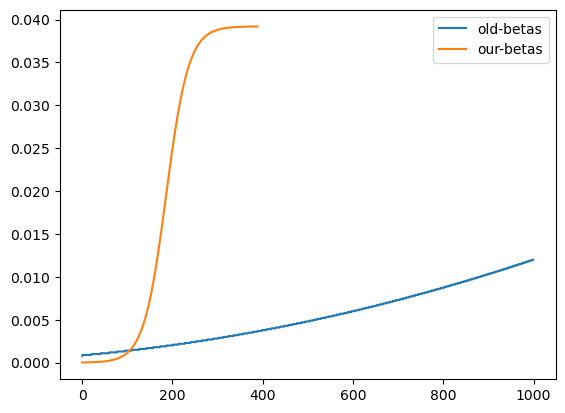

In [41]:
plt.plot(their_betas, label='old-betas')
plt.plot(our_betas*3, label='our-betas')
plt.legend()
plt.show()

In [34]:
len(our_betas)

751